In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from cnn import SimpleCNN


In [10]:
data_path = "data"
model_folder = "models"
plot_folder = "plots"
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print("CUDA version", torch.version.cuda)

Using cuda device
CUDA version 12.4


In [11]:
l0 = 4718 # angstrom, start of spectrum
l1 = 7890 # angstrom, end of spectrum
spectra = np.load(f"{data_path}/spectra.npy")
# normalize
spectra = np.log(np.maximum(spectra, 0.2))
spectra_length = spectra.shape[1]
# labels: mass, age, l_bol, dist, t_eff, log_g, fe_h, SNR
labelNames = ["mass", "age", "l_bol", "dist", "t_eff", "log_g", "fe_h", "SNR"]
labels = np.load(f"{data_path}/labels.npy")
# We only use the three labels: t_eff, log_g, fe_h
labelNames = labelNames[-4:-1]
labels = labels[:, -4:-1]
n_labels = labels.shape[1]

In [12]:
print(spectra)
print(type(spectra))
print(spectra.shape) # 8914, 16384 (number of spectra, length of each spectrum)

print(labelNames)
print(labels)
print(labels.shape)

[[-0.0182943  -0.01366498  0.00676046 ...  0.06692334  0.10649246
   0.20378247]
 [-0.04135376 -0.06643463 -0.11676109 ...  0.00545667  0.07043431
   0.20460529]
 [-0.07064897 -0.02532261 -0.01220473 ...  0.03334754  0.09973088
   0.2310698 ]
 ...
 [-0.02218651  0.00892046  0.01012168 ...  0.01696421  0.11753463
   0.2195622 ]
 [-0.1282717  -0.02985833  0.01431552 ...  0.00762445  0.06368124
   0.198687  ]
 [-0.03660118 -0.02355827 -0.01801771 ...  0.07393676  0.15408995
   0.2704637 ]]
<class 'numpy.ndarray'>
(8914, 16384)
['t_eff', 'log_g', 'fe_h']
[[ 5.6880371e+03  4.4140868e+00 -1.8493813e-01]
 [ 5.7284995e+03  4.1684337e+00  1.6166866e-01]
 [ 5.1330986e+03  4.5885820e+00 -1.7365435e-01]
 ...
 [ 5.9974995e+03  4.2767024e+00 -2.3521969e-01]
 [ 5.6752285e+03  4.2371678e+00 -4.4423985e-01]
 [ 5.6668794e+03  4.4761324e+00 -4.1714379e-01]]
(8914, 3)


### Visualize some spectra

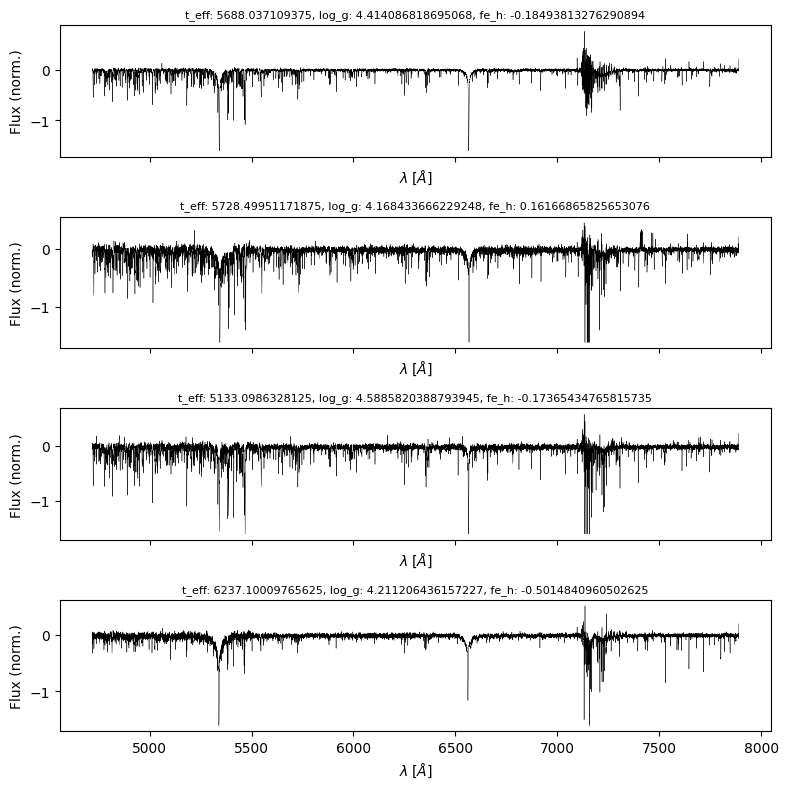

In [13]:
x = np.linspace(l0, l1, spectra_length)
fig, axs = plt.subplots(4, sharex=True, figsize=(8, 8))

for i in range(4):
    axs[i].plot(x, spectra[i], linewidth=0.3, color="black")
    axs[i].set_title(f"{labelNames[0]}: {labels[i, 0]}, {labelNames[1]}: {labels[i, 1]}, {labelNames[2]}: {labels[i, 2]}", fontsize=8)
    axs[i].set_ylabel("Flux (norm.)")
    axs[i].set_xlabel(r"$\lambda \; [Å]$")
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "spectra.png"))

### Create dataset and dataloader

In [14]:
####### DATASET #######
input_tensor = torch.Tensor(spectra).unsqueeze(1).to(device) # add dim for 1 channel
print(input_tensor)
print(input_tensor.shape)
labels_tensor = torch.Tensor(labels).to(device)

full_dataset = torch.utils.data.TensorDataset(input_tensor, labels_tensor)
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])

####### DATA LOADER #######
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

tensor([[[-0.0183, -0.0137,  0.0068,  ...,  0.0669,  0.1065,  0.2038]],

        [[-0.0414, -0.0664, -0.1168,  ...,  0.0055,  0.0704,  0.2046]],

        [[-0.0706, -0.0253, -0.0122,  ...,  0.0333,  0.0997,  0.2311]],

        ...,

        [[-0.0222,  0.0089,  0.0101,  ...,  0.0170,  0.1175,  0.2196]],

        [[-0.1283, -0.0299,  0.0143,  ...,  0.0076,  0.0637,  0.1987]],

        [[-0.0366, -0.0236, -0.0180,  ...,  0.0739,  0.1541,  0.2705]]],
       device='cuda:0')
torch.Size([8914, 1, 16384])


### Create model and loss

In [15]:
model = SimpleCNN(inputdim=spectra_length).to(device)
print(model)
total_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable parameters", total_params)

####### LOSS AND OPTIMIZER #######
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

SimpleCNN(
  (conv1): Conv1d(1, 2, kernel_size=(4,), stride=(1,), padding=same)
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(2, 4, kernel_size=(4,), stride=(1,), padding=same)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=3, bias=True)
)
Trainable parameters 532913


In [16]:
####### TRAIN #######
n_epochs = 400
print("Starting training loop with {} epochs".format(n_epochs))
train_losses = []
test_losses = []
best_test_loss = 99999999999
earlystop_counter = 0
earlystop_patience = 20
stop_now = False

for epoch in range(n_epochs):
    if stop_now:
        break
    start_time = time.time()
    train_loss = 0
    for i, (batch_input, batch_label) in enumerate(train_loader):
        model.train()
        # reset gradients
        optimizer.zero_grad()
        # propagate input
        output = model(batch_input)
        # compute loss
        loss = criterion(output, batch_label)
        # compute gradient
        loss.backward()
        # update weights
        optimizer.step()
        # save loss
        train_loss += loss.item()
    ### END OF EPOCH ###
    # run validation
    with torch.no_grad():
        # val loss for the epoch
        test_loss = 0.0
        model.eval()  # Set the model to evaluation mode
        for batch_input, batch_label in test_loader:
            output = model(batch_input)
            loss = criterion(output, batch_label)
            test_loss += loss.item()
        test_loss = test_loss/len(test_dataset)  # Calculate the average val loss
        test_losses.append(test_loss)
    # add losses
    train_loss = train_loss/len(train_dataset)  # Calculate the average train loss pe event
    train_losses.append(train_loss)
    end_time = time.time()
    if epoch % 10 == 0:
        # print progress
        print("Epoch", epoch, "train loss", train_loss, "test loss", test_loss, "time current epoch", end_time-start_time)
        # save model
        # model_path = os.path.join(model_folder, f"simpleCNN_epoch_{epoch}.pth")
        # torch.save(model.state_dict(), model_path)
        # plot loss
        plt.figure()
        plt.plot(train_losses, label="Train", linewidth=0.5)
        plt.plot(test_losses, label="Test", linewidth=0.5)
        plt.title("Astronomy CNN loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Event Loss")
        plt.yscale("log")
        plt.legend()
        plt.savefig(os.path.join(plot_folder, "loss.png"))
        plt.close()
    # EARLY STOPPING?
    if test_loss < best_test_loss:
        model_path = os.path.join(model_folder, "simpleCNN_best.pth")
        torch.save(model.state_dict(), model_path)
        earlystop_counter = 0
    else:
        earlystop_counter += 1
        if earlystop_counter > earlystop_patience:
            stop_now = True
            print("Early stopping at epoch", epoch, " with val loss", test_loss)
            break

Starting training loop with 400 epochs
Epoch 0 train loss 18562.919985956778 test loss 1222.1680630085577 time current epoch 0.8555564880371094
Epoch 10 train loss 177.10795082353303 test loss 192.6747745466821 time current epoch 0.8427145481109619
Epoch 20 train loss 80.81028678239362 test loss 153.64005068041527 time current epoch 0.9019434452056885
Epoch 30 train loss 72.02751463474482 test loss 62.67902125092066 time current epoch 0.8449320793151855
Epoch 40 train loss 61.132087660450914 test loss 77.51763018641275 time current epoch 0.8425016403198242
Epoch 50 train loss 54.19770490354323 test loss 42.79955273766309 time current epoch 0.8309774398803711
Epoch 60 train loss 58.49294389263673 test loss 85.59513209350449 time current epoch 0.8321573734283447
Epoch 70 train loss 42.48753783974297 test loss 59.19508644386574 time current epoch 0.8553037643432617
Epoch 80 train loss 38.7986233594106 test loss 44.73036373665036 time current epoch 0.8217542171478271
Epoch 90 train loss 31

### Plot losses

In [18]:
####### PLOT LOSS #######
plt.figure()
plt.plot(train_losses, label="Train", linewidth=0.5)
plt.plot(test_losses, label="Test", linewidth=0.5)
plt.title("Astronomy CNN loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.savefig(os.path.join(plot_folder, "loss.png"))
plt.close()

### Open best model and plot some predictions

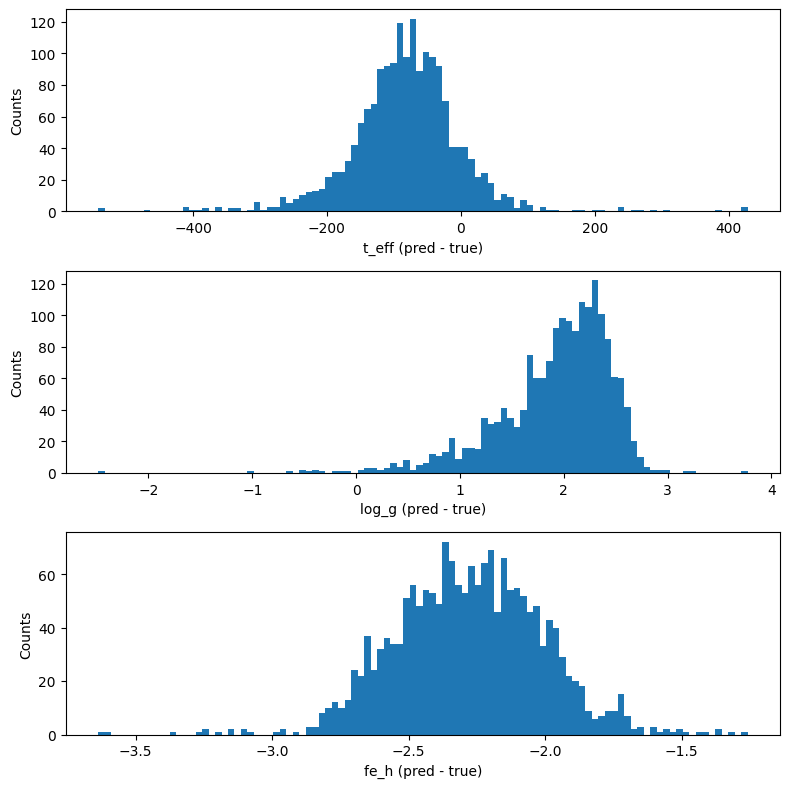

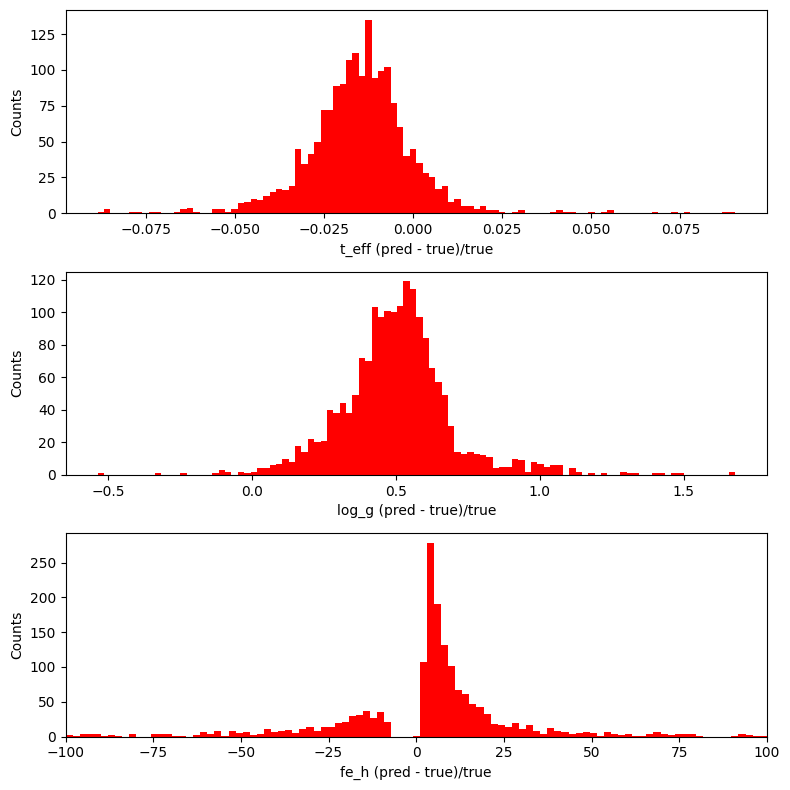

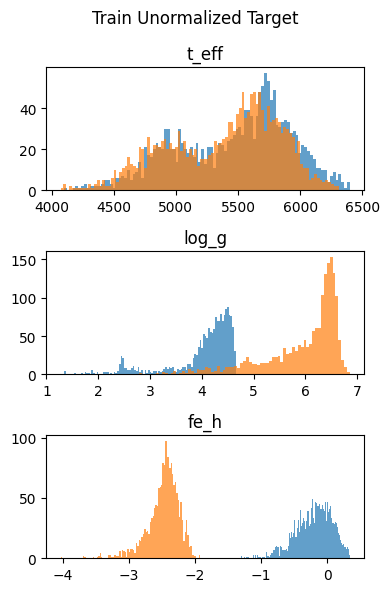

In [34]:
model_path = os.path.join(model_folder, "simpleCNN_best.pth")
model.load_state_dict(torch.load(model_path))

# predict on test
model.eval()
pred = []
true = []
errors = []
relative_errors = []
with torch.no_grad():
    for i, (batch_input, batch_label) in enumerate(test_loader):
        output = model(batch_input)
        error = (output - batch_label)
        # reverse normalization
        # error = error.cpu() * label_stds + label_means
        # batch_label = batch_label.cpu() * label_stds + label_means
        relative_error = error / batch_label
        # append
        true.append(batch_label)
        pred.append(output)
        errors.append(error)
        relative_errors.append(relative_error)

true = torch.cat(true, dim=0).cpu().numpy()
pred = torch.cat(pred, dim=0).cpu().numpy()
errors = torch.cat(errors, dim=0)
relative_errors = torch.cat(relative_errors, dim=0)

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
for i in range(3):
    axs[i].hist(errors[:, i].cpu().numpy(), bins=100)
    axs[i].set_xlabel(f"{labelNames[i]} (pred - true)")
    axs[i].set_ylabel("Counts")
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "error.png"))

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
for i in range(3):
    bins=100
    if labelNames[i] == "fe_h":
        axs[i].set_xlim(-100, 100)
        bins = np.linspace(-100, 100, bins)
    axs[i].hist(relative_errors[:, i].cpu().numpy(), bins=bins, color="red")
    axs[i].set_xlabel(f"{labelNames[i]} (pred - true)/true")
    axs[i].set_ylabel("Counts")
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "error_relative.png"))


# visualize labels
fig, axs = plt.subplots(3, figsize=(4, 6))
fig.suptitle("Train Unnormalized Target")
for i in range(3):
    axs[i].hist(true[:, i], bins=100, alpha=0.7, label="True")
    axs[i].hist(pred[:, i], bins=100, alpha=0.7, label="Pred")
    axs[i].set_title(labelNames[i])
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "pred.png"))

plt.show()